# Edits to Script 08-slope-to-edges

This Notebook helped edit and test Script 08 for proxanalysis 2024

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Script editing

In [6]:
schema = 'osmnx'
#table_sufix = 'elevation_24' #sufix for nodes and edges table names
grl_path = '../../../data/external/MDE/'
#main(schema, folder_sufix, year, grl_path, save=True)

metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020' # Cities 2020

# --------------- SCRIPT
# Load cities (municipalities)
query = f"SELECT city FROM {metro_schema}.{metro_table}"
metro_df = aup.df_from_query(query)
city_list = list(metro_df.city.unique())
k = len(city_list)

In [7]:
city = 'Aguascalientes'

In [8]:
# Creates empty GeoDataFrame to store specified municipality polygons and hex grid
mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

#Define projections for municipalities and hexgrids
mun_gdf = mun_gdf.set_crs("EPSG:4326")

# Creates query to download OSMNX nodes and edges from the DB
# by metropolitan area or capital using the municipality geometry
G, nodes, edges = aup.graph_from_hippo(mun_gdf, schema='osmnx', edges_folder='edges_23_line', nodes_folder='nodes_23_point')
aup.log(f"Downloaded {len(nodes)} nodes and {len(edges)} edges from database for {city}")

In [44]:
# Show
print(nodes.shape)
nodes.head(1)

(55006, 5)


,x,y,street_count,geometry,city
osmid,,,,,
272921360,-102.295073,21.872876,3,POINT (-102.29507 21.87288),Aguascalientes


In [45]:
# Show
print(edges.shape)
edges.head(1)

(128284, 16)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
u,v,key,,,,,,,,,,,,,,,,
1417904191,4507389643,0,1036118103,False,None,Calle San Martín de la Cantera,unclassified,None,74.345,"LINESTRING (-102.35592 21.85416, -102.35540 21...",None,None,None,None,None,None,None,Aguascalientes


In [14]:
mde_path = [] # list to append mde path strings
#Gathers state codes for MDE
for e in mun_gdf.CVE_ENT.unique():
    tmp_path = grl_path + (f'CEM_V3_20170619_R15_E{e}_TIF/')

    #search for files in tmp_path for .tif
    for f in os.listdir(tmp_path):
        if f.endswith('.tif'):
            mde_path.append(tmp_path+f)

In [16]:
#elevations to nodes
G_elev_mde = ox.elevation.add_node_elevations_raster(G, mde_path)
#slope to edges
G_elev_mde = ox.elevation.add_edge_grades(G_elev_mde, add_absolute=True, precision=3)
nodes_elev_mde, edges_elev_mde = ox.graph_to_gdfs(G_elev_mde, nodes=True, edges=True)
mean_elev = round(nodes_elev_mde.elevation.mean(),2)
mean_slope = round(edges_elev_mde.grade_abs.mean(),2)
aup.log(f"Assigned a mean elevation of {mean_elev} to nodes "+
f"\nand mean slope of {mean_slope} to edges")
# reset index for upload
nodes_elev_mde.reset_index(inplace=True)
edges_elev_mde.reset_index(inplace=True)

#set street_count as float
nodes_elev_mde["street_count"] = nodes_elev_mde["street_count"].astype(float)

/tmp/ipykernel_90156/1505067729.py:4: UserWarning: the `precision` parameter is deprecated and will be removed in a future release
  G_elev_mde = ox.elevation.add_edge_grades(G_elev_mde, add_absolute=True, precision=3)


In [27]:
edges_elev_mde.head(1)

,u,v,key,osmid,oneway,name,highway,length,geometry,city,...,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
0,1417904191,4507389643,0,1036118103,False,Calle San Martín de la Cantera,unclassified,74.345,"LINESTRING (-102.35592 21.85416, -102.35540 21...",Aguascalientes,...,0.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
nodes_elev_mde.head(1)

,osmid,x,y,street_count,city,elevation,geometry
0,1417904191,-102.355922,21.85416,3.0,Aguascalientes,1867.0,POINT (-102.35592 21.85416)


## Test (After running Aguascalientes on Script 08 on Visual) 

In [2]:
# Load test
saved_schema = 'osmnx'
saved_nodes_table = 'nodes_elevation_23_point'
saved_edges_table = 'edges_elevation_23_line'

In [3]:
query = f"SELECT * FROM {saved_schema}.{saved_nodes_table}"
nodes_test = aup.gdf_from_query(query)

# Show
print(nodes_test.shape)
nodes_test.head(1)

(55006, 6)


,osmid,x,y,street_count,elevation,geometry
0,1417904191,-102.355922,21.85416,3.0,1867.0,POINT (-102.35592 21.85416)


In [4]:
query = f"SELECT * FROM {saved_schema}.{saved_edges_table}"
edges_test = aup.gdf_from_query(query)

# Show
print(edges_test.shape)
edges_test.head(1)

(128284, 20)


,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
0,1417904191,4507389643,0,1036118103,False,Calle San Martín de la Cantera,unclassified,74.345,"LINESTRING (-102.35592 21.85416, -102.35540 21...",0.027,0.027,None,None,None,None,None,None,None,None,None


## Test - (aup.graph_from_hippo edges) vs (saved+dbeaver deleteddups edges_elevation)

In [54]:
city = 'Guadalajara'
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
# Creates empty GeoDataFrame to store specified municipality polygons and hex grid
mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

### Download all elevation data near city

<Axes: >

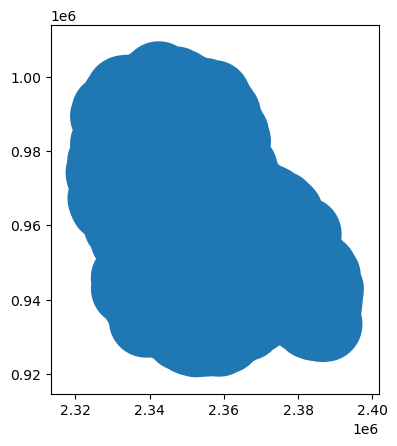

In [55]:
aoi = mun_gdf.to_crs("EPSG:6372")
aoi = aoi.buffer(10000)
aoi.plot()

In [56]:
# Load test
elevation_schema = 'osmnx'
elevation_nodes_table = 'nodes_elevation_23_point'
elevation_edges_table = 'edges_elevation_23_line'

nodes_elevation = aup.gdf_from_polygon(aoi,elevation_schema,elevation_nodes_table)
edges_elevation = aup.gdf_from_polygon(aoi,elevation_schema,elevation_edges_table)

In [57]:
# Show
print(nodes_elevation.shape)
nodes_elevation.head(1)

(187215, 6)


,osmid,x,y,street_count,elevation,geometry
0,2858735498,-103.421216,20.364457,4.0,2835.0,POINT (-103.42122 20.36446)


In [58]:
# Show
print(edges_elevation.shape)
edges_elevation.head(1)

(448282, 20)


,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
0,4682698883,4682698886,0,474271855,False,Privada La Reserva Chica,residential,27.677,"LINESTRING (-103.37357 20.57555, -103.37355 20...",0.0,0.0,None,None,None,None,None,None,None,None,None


### Load nodes and edges 2023 with aup.graph_from_hippo with city mun_gdf

In [63]:
# Load test
schema = 'osmnx'
nodes_table = 'nodes_osmnx_23_point'
edges_table = 'edges_osmnx_23_line'

_,nodes,edges = aup.graph_from_hippo(mun_gdf,schema,edges_table,nodes_table)

In [64]:
# Show
print(nodes.shape)
nodes.head(1)

(187215, 5)


,x,y,street_count,geometry,city
osmid,,,,,
28751344,-103.306309,20.711533,3,POINT (-103.30631 20.71153),Guadalajara


In [65]:
# Show
print(edges.shape)
edges.head(1)

(448282, 16)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
u,v,key,,,,,,,,,,,,,,,,
2858735498,2858736708,0,295103470,False,None,Sendero Cerro Viejo,path,None,1872.523,"LINESTRING (-103.42122 20.36446, -103.42123 20...",None,None,None,None,None,None,None,Guadalajara


### Find if there are nodes in nodes gdf that are not present on nodes_elevation gdf

In [66]:
nodes_merge = nodes.merge(nodes_elevation[['osmid']], on=['osmid'], how='left', indicator=True)
nodes_missing = nodes_merge.loc[nodes_merge['_merge']=='left_only']
nodes_missing

,osmid,x,y,street_count,geometry,city,_merge


### Find if there are edges in edges gdf that are not present on edges_elevation gdf

In [67]:
edges_merge = edges.merge(edges_elevation[['osmid']], on=['osmid'], how='left', indicator=True)
edges_missing = edges_merge.loc[edges_merge['_merge']=='left_only']
edges_missing

,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city,_merge


<Axes: >

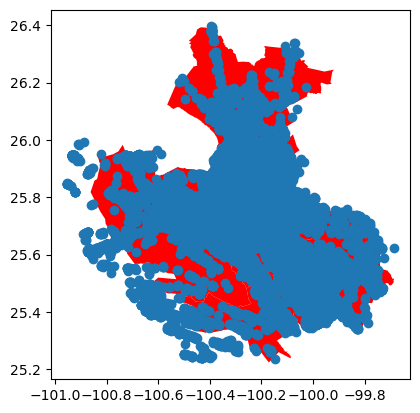

In [53]:
fig,ax = plt.subplots(1,1)

nodes_elevation.plot(ax=ax,zorder=1)
mun_gdf.plot(ax=ax,zorder=0,color='red')

## Test - Quantity edges_osmnx_23_line vs edges_elevation_23_line vs edges_speed_23_line

In [9]:
# Load all available cities
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
query = f"SELECT city FROM {metro_schema}.{metro_table}"
metro_df = aup.df_from_query(query)
city_list = list(metro_df.city.unique())
k = len(city_list)
aup.log(f'--- Loaded city list with {k} cities.')

# In metro_gdf_2020 CDMX was separated from the rest of ZMVM. 
# For current edges speed analysis, it's better if they are joined together.
if metro_table == 'metro_gdf_2020':
    city_list.remove('CDMX') 

# Create mun_gdf for each city and run main function
i = 0
df = pd.DataFrame()
for city in city_list:
    print("--"*40)
    print(f"--- Loading municipalities for city {i+1}/{k}:{city}.")

    #########################################
    df.loc[i,'city'] = city
    #########################################
    
    # Creates empty GeoDataFrame to store specified municipality polygons and hex grid
    mun_gdf = gpd.GeoDataFrame()

    if (metro_table =='metro_gdf_2020') and (city == 'ZMVM'):
        # Loads ZMVM
        city = 'ZMVM'
        query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
        gdf_1 = aup.gdf_from_query(query, geometry_col='geometry')
        # Loads CDMX
        city = 'CDMX'
        query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
        gdf_2 = aup.gdf_from_query(query, geometry_col='geometry')
        # Concatenates both
        mun_gdf = pd.concat([gdf_1,gdf_2])
    else:
        # Loads current city
        query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
        mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

    #Define projections for municipalities and hexgrids
    mun_gdf = mun_gdf.set_crs("EPSG:4326")

    osmnx_schema = 'osmnx'
    # Load nodes and edges
    print(f"--- Counting nodes and edges")
    nodes_table = 'nodes_osmnx_23_point'
    edges_table = 'edges_osmnx_23_line'
    _,nodes,edges = aup.graph_from_hippo(mun_gdf,osmnx_schema,edges_table,nodes_table)
    #########################################
    df.loc[i,'nodes'] = nodes.shape[0]
    del nodes
    df.loc[i,'edges'] = edges.shape[0]
    del edges
    #########################################

    # Load nodes_elevation and edges_elevation
    print(f"--- Counting nodes elevation and edges elevation")
    elevation_nodes_table = 'nodes_elevation_23_point'
    elevation_edges_table = 'edges_elevation_23_line'
    _,nodes_elevation,edges_elevation = aup.graph_from_hippo(mun_gdf,osmnx_schema,elevation_edges_table,elevation_nodes_table)
    ########################################
    df.loc[i,'nodes_elev'] = nodes_elevation.shape[0]
    del nodes_elevation
    df.loc[i,'edges_elev'] = edges_elevation.shape[0]
    del edges_elevation
    #########################################

    # Load edges_speed
    print(f"--- Counting edges speed")
    speed_edges_table = 'edges_speed_23_line'
    _,_,edges_speed = aup.graph_from_hippo(mun_gdf,osmnx_schema,speed_edges_table,elevation_nodes_table)
    ########################################
    df.loc[i,'edges_speed'] = edges_speed.shape[0]
    del edges_speed
    #########################################

    i = i + 1

df['nodes_check'] = df['nodes'] - ((df['nodes']+df['nodes_elev'])/2)
df['edges_check'] = df['edges'] - ((df['edges']+df['edges_elev']+df['edges_speed'])/3)

--------------------------------------------------------------------------------
--- Loading municipalities for city 1/71:Aguascalientes.
--- Counting nodes and edges
--- Counting nodes elevation and edges elevation
--- Counting edges speed
--------------------------------------------------------------------------------
--- Loading municipalities for city 2/71:Ensenada.
--- Counting nodes and edges
--- Counting nodes elevation and edges elevation
--- Counting edges speed
--------------------------------------------------------------------------------
--- Loading municipalities for city 3/71:Mexicali.
--- Counting nodes and edges
--- Counting nodes elevation and edges elevation
--- Counting edges speed
--------------------------------------------------------------------------------
--- Loading municipalities for city 4/71:Tijuana.
--- Counting nodes and edges
--- Counting nodes elevation and edges elevation
--- Counting edges speed
-------------------------------------------------------

In [11]:
df.head(40)

,city,nodes,edges,nodes_elev,edges_elev,edges_speed,nodes_check,edges_check
0,Aguascalientes,55006.0,128284.0,55006.0,128284.0,128284.0,0.0,0.000000
1,Ensenada,27696.0,75147.0,27696.0,75147.0,75147.0,0.0,0.000000
2,Mexicali,51374.0,144291.0,51374.0,144291.0,144291.0,0.0,0.000000
3,Tijuana,93092.0,232591.0,93092.0,232591.0,232591.0,0.0,0.000000
4,La Paz,19726.0,55097.0,19726.0,55097.0,55097.0,0.0,0.000000
5,Los Cabos,23427.0,60516.0,23427.0,60512.0,60512.0,0.0,2.666667
6,Campeche,13744.0,35887.0,13744.0,35887.0,35887.0,0.0,0.000000
7,Laguna,66571.0,175337.0,66571.0,175337.0,175337.0,0.0,0.000000
8,Monclova,19717.0,56335.0,19717.0,56335.0,56335.0,0.0,0.000000
9,Piedras Negras,11935.0,34127.0,11935.0,34127.0,34127.0,0.0,0.000000


In [15]:
df.tail(30)

,city,nodes,edges,nodes_elev,edges_elev,edges_speed,nodes_check,edges_check
40,San Martin,15381.0,37836.0,15381.0,37836.0,37836.0,0.0,0.000000
41,Tehuacan,14947.0,39770.0,14947.0,39770.0,39770.0,0.0,0.000000
42,Queretaro,102786.0,240156.0,102786.0,240156.0,240156.0,0.0,0.000000
43,Cancun,36137.0,88098.0,36137.0,88098.0,88098.0,0.0,0.000000
44,Chetumal,13047.0,34883.0,13047.0,34883.0,34883.0,0.0,0.000000
45,Playa,15399.0,36803.0,15399.0,36803.0,36803.0,0.0,0.000000
46,SLP,58251.0,143003.0,58251.0,143003.0,143003.0,0.0,0.000000
47,Culiacan,46277.0,124843.0,46277.0,124843.0,124843.0,0.0,0.000000
48,Los Mochis,21927.0,61892.0,21927.0,61892.0,61892.0,0.0,0.000000
49,Mazatlan,21858.0,57073.0,21858.0,57073.0,57073.0,0.0,0.000000


In [2]:
city = 'Hermosillo'
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
# Creates empty GeoDataFrame to store specified municipality polygons and hex grid
mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

In [4]:
# Load test
schema = 'osmnx'
nodes_table = 'nodes_osmnx_23_point'
edges_table = 'edges_osmnx_23_line'

_,_,edges = aup.graph_from_hippo(mun_gdf,schema,edges_table,nodes_table)

#Show
print(edges.shape)
edges.head(1)

(133930, 16)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
u,v,key,,,,,,,,,,,,,,,,
6957832733,7095804116,0,743329738,False,None,None,unclassified,None,4454.285,"LINESTRING (-111.37060 28.31081, -111.37256 28...",None,None,None,None,None,None,None,Hermosillo


In [5]:
# Load test
schema = 'osmnx'
nodes_elev_table = 'nodes_elevation_23_point'
edges_elev_table = 'edges_elevation_23_line'

_,_,edges_elevation = aup.graph_from_hippo(mun_gdf,schema,edges_elev_table,nodes_elev_table)

#Show
print(edges_elevation.shape)
edges_elevation.head(1)

(133928, 17)


,,,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
u,v,key,,,,,,,,,,,,,,,,,
498658558,7095798804,0,40940321,False,Calle 13,tertiary,1978.467,"LINESTRING (-111.47356 28.70399, -111.46364 28...",0.002,0.002,None,None,None,SON 108,None,None,None,None,None


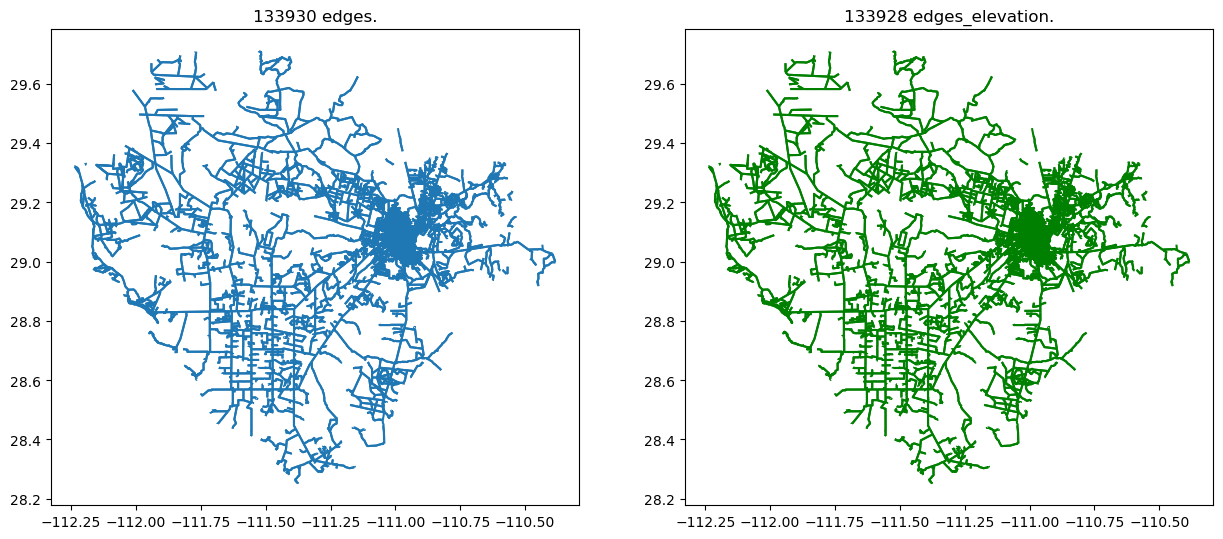

In [41]:
fig,ax = plt.subplots(1,2,figsize=(15,15))

# Ax 0
edges.plot(ax=ax[0],zorder=0)
ax[0].title.set_text(f'{edges.shape[0]} edges.')
# Ax 1
edges_elevation.plot(ax=ax[1],color='green')
ax[1].title.set_text(f'{edges_elevation.shape[0]} edges_elevation.')

In [15]:
org = edges.reset_index()
elev = edges_elevation.reset_index()

# Which edges are in 'left_only' (edges gdf but not in edges_elevation)
edges_merge = org.merge(elev[['osmid']], on=['osmid'], how='left', indicator=True)
edges_missing = edges_merge.loc[edges_merge['_merge']=='left_only']
edges_missing

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city,_merge
933284,4748113946,4748113978,0,"[481925056, 481925061]",False,None,None,track,None,6023.504,"LINESTRING (-111.02873 28.61813, -111.02923 28...",None,None,None,None,None,None,None,Guaymas,left_only
933295,4748113978,4748113946,0,"[481925056, 481925061]",False,None,None,track,None,6023.504,"LINESTRING (-111.05773 28.61198, -111.05859 28...",None,None,None,None,None,None,None,Guaymas,left_only


<Axes: >

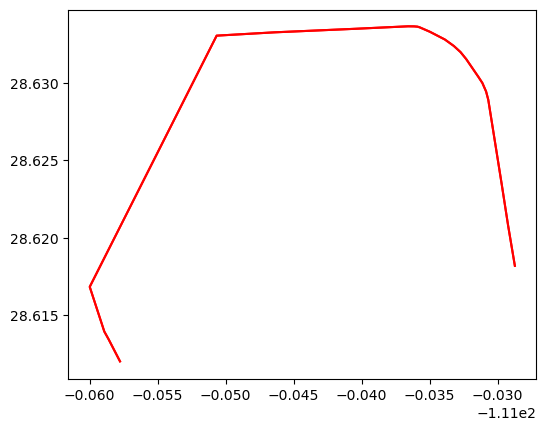

In [47]:
edges_missing.plot(color='red')

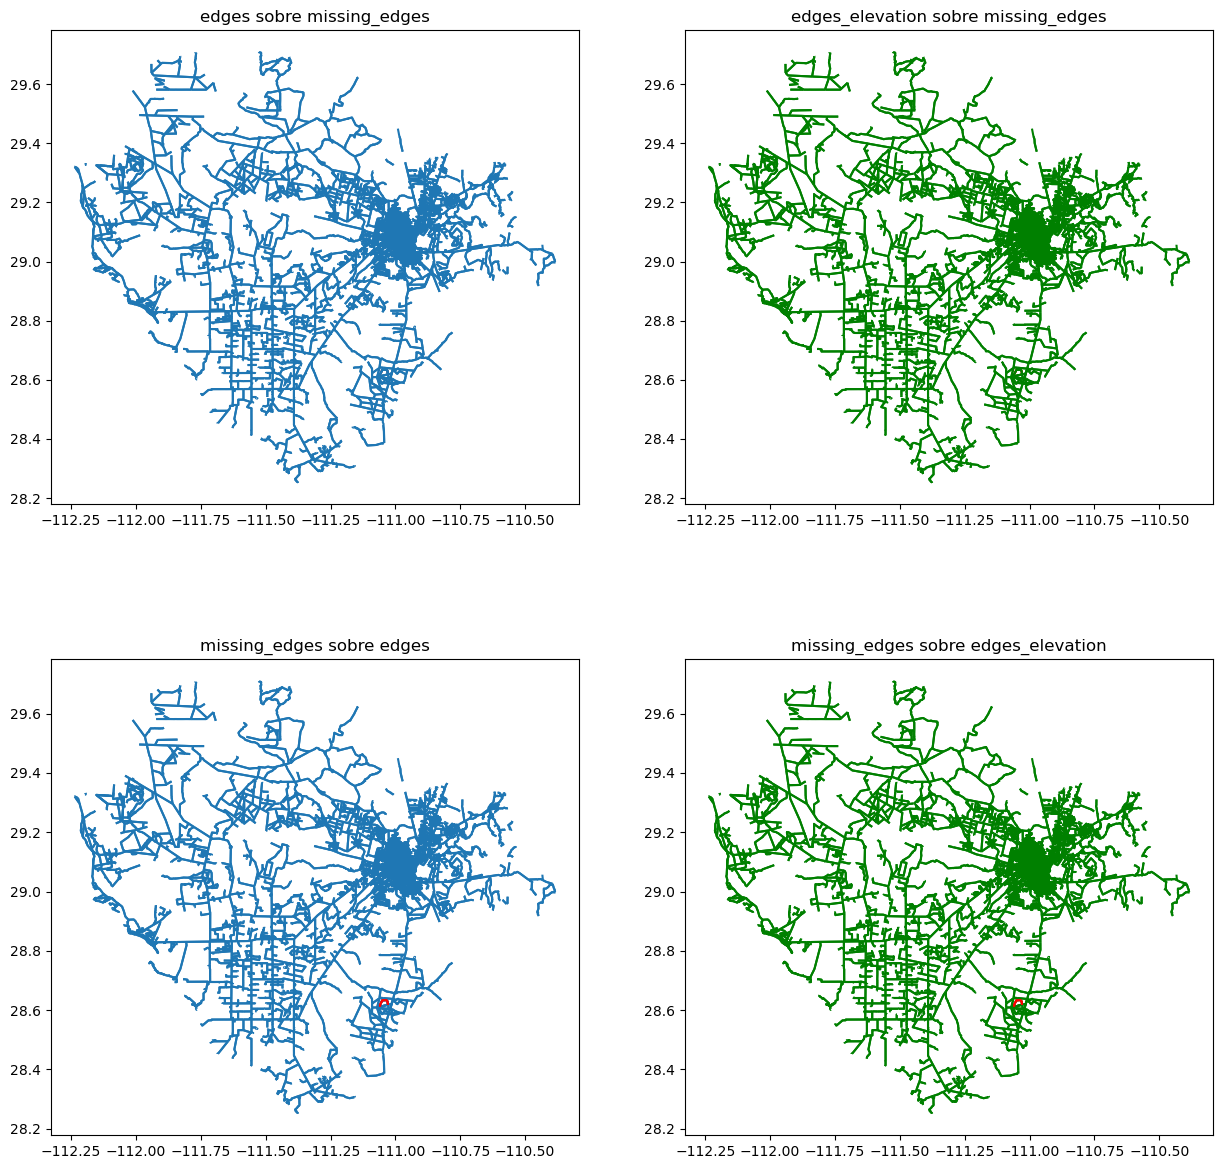

In [48]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15,15))

# Ax1
edges.plot(ax=ax1,zorder=1)
edges_missing.plot(ax=ax1,color='red',zorder=0)
ax1.title.set_text('edges sobre missing_edges')
# Ax2
edges_elevation.plot(ax=ax2,color='green',zorder=1)
edges_missing.plot(ax=ax2,color='red',zorder=0)
ax2.title.set_text('edges_elevation sobre missing_edges')
# Ax3
edges_missing.plot(ax=ax3,color='red',zorder=1)
edges.plot(ax=ax3,zorder=0)
ax3.title.set_text('missing_edges sobre edges')
# Ax4
edges_missing.plot(ax=ax4,color='red',zorder=1)
edges_elevation.plot(ax=ax4,color='green',zorder=0)
ax4.title.set_text('missing_edges sobre edges_elevation')

### Nodes gdf del nodo 46 al nodo 78

In [100]:
original_inicio_fin = org.loc[(org.u == 4748113946) & (org.v == 4748113978) & (org.key == 0) |
                              (org.u == 4748113978) & (org.v == 4748113946) & (org.key == 0)]
original_inicio_fin

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
58115,4748113946,4748113978,0,"[481925056, 481925061]",False,None,None,track,None,6023.504,"LINESTRING (-111.02873 28.61813, -111.02923 28...",None,None,None,None,None,None,None,Guaymas
58117,4748113978,4748113946,0,"[481925056, 481925061]",False,None,None,track,None,6023.504,"LINESTRING (-111.05773 28.61198, -111.05859 28...",None,None,None,None,None,None,None,Guaymas
58252,4748113946,4748113978,0,758748416,False,None,None,track,None,2924.964,"LINESTRING (-111.02873 28.61813, -111.03658 28...",None,None,None,None,None,None,None,Hermosillo
58264,4748113978,4748113946,0,758748416,False,None,None,track,None,2924.964,"LINESTRING (-111.05773 28.61198, -111.05539 28...",None,None,None,None,None,None,None,Hermosillo


### Nodes elevation gdf del nodo 46 al nodo 78

In [99]:
elev_inicio_fin = elev.loc[(elev.u == 4748113946) & (elev.v == 4748113978) & (elev.key == 0) |
                           (elev.u == 4748113978) & (elev.v == 4748113946) & (elev.key == 0)]
elev_inicio_fin

,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
55873,4748113946,4748113978,0,758748416,False,None,track,2924.964,"LINESTRING (-111.02873 28.61813, -111.03658 28...",-0.005,0.005,None,None,None,None,None,None,None,None,None
55878,4748113978,4748113946,0,758748416,False,None,track,2924.964,"LINESTRING (-111.05773 28.61198, -111.05539 28...",0.005,0.005,None,None,None,None,None,None,None,None,None


### Nodes gdf del nodo 46 al nodo 78 pasando por el nodo 82

In [102]:
original_recorrido_largo = org.loc[((org.u == 4748113978) & (org.v == 4748110782) & (org.key == 0)) | 
                                   ((org.u == 4748110782) & (org.v == 4748113978) & (org.key == 0)) |
                                   ((org.u == 4748113946) & (org.v == 4748110782) & (org.key == 0)) | 
                                   ((org.u == 4748110782) & (org.v == 4748113946) & (org.key == 0))] 
original_recorrido_largo

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
58237,4748110782,4748113978,0,481925056,False,None,None,track,None,2605.783,"LINESTRING (-111.05066 28.63305, -111.05999 28...",None,None,None,None,None,None,None,Hermosillo
58239,4748110782,4748113946,0,481925061,False,None,None,track,None,3417.721,"LINESTRING (-111.05066 28.63305, -111.04646 28...",None,None,None,None,None,None,None,Hermosillo
58249,4748113946,4748110782,0,481925061,False,None,None,track,None,3417.721,"LINESTRING (-111.02873 28.61813, -111.02923 28...",None,None,None,None,None,None,None,Hermosillo
58263,4748113978,4748110782,0,481925056,False,None,None,track,None,2605.783,"LINESTRING (-111.05773 28.61198, -111.05859 28...",None,None,None,None,None,None,None,Hermosillo


### Nodes elevation gdf del nodo 46 al nodo 78 pasando por el nodo 82

In [109]:
elev_recorrido_largo = elev.loc[((elev.u == 4748113978) & (elev.v == 4748110782) & (elev.key == 0)) | 
                                ((elev.u == 4748110782) & (elev.v == 4748113978) & (elev.key == 0)) |
                                ((elev.u == 4748113946) & (elev.v == 4748110782) & (elev.key == 0)) | 
                                ((elev.u == 4748110782) & (elev.v == 4748113946) & (elev.key == 0))] 
elev_recorrido_largo

,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
55875,4748113946,4748110782,0,481925061,False,None,track,3417.721,"LINESTRING (-111.02873 28.61813, -111.02923 28...",-0.002,0.002,None,None,None,None,None,None,None,None,None
55880,4748113978,4748110782,0,481925056,False,None,track,2605.783,"LINESTRING (-111.05773 28.61198, -111.05859 28...",0.003,0.003,None,None,None,None,None,None,None,None,None
55998,4748110782,4748113978,0,481925056,False,None,track,2605.783,"LINESTRING (-111.05066 28.63305, -111.05999 28...",-0.003,0.003,None,None,None,None,None,None,None,None,None
56000,4748110782,4748113946,0,481925061,False,None,track,3417.721,"LINESTRING (-111.05066 28.63305, -111.04646 28...",0.002,0.002,None,None,None,None,None,None,None,None,None


<Axes: >

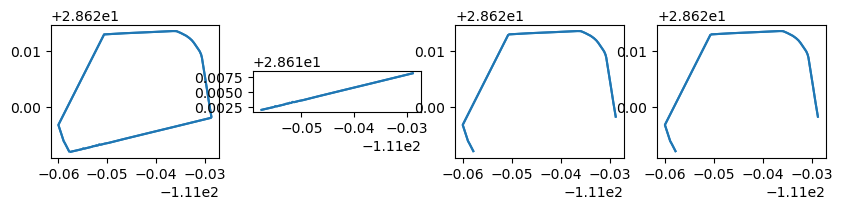

In [110]:
fig,ax = plt.subplots(1,4,figsize=(10,10))

original_inicio_fin.plot(ax=ax[0])
elev_inicio_fin.plot(ax=ax[1])
original_recorrido_largo.plot(ax=ax[2])
elev_recorrido_largo.plot(ax=ax[3])